In [1]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [3]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [4]:
from patchseq_utils import plotting as plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')

In [5]:
from neuron_morphology.swc_io import morphology_from_swc
from patchseq_utils.lims import get_swc_path

In [7]:
from collections import defaultdict


from neuron_morphology.constants import (
    SOMA, AXON, APICAL_DENDRITE, BASAL_DENDRITE)

def visit(morphology, node, index, step, dist, dendro):
    if node['type'] == SOMA:
        return index, dist
    compartment = morphology.get_compartment_for_node(node)
    dist += morphology.get_compartment_length(compartment)
            
    if dist >= index*step:
        area = np.pi*(node['radius']**2)
        dendro[index].append(area)
        index += 1
    return index, dist

def calculate_cross_section_profile(morphology, root=None, index=0, step=5, dist=0, dendro=None, node_types=None):
    if index==2:
        return dendro
    if node_types is None:
        node_types = [SOMA, AXON, APICAL_DENDRITE, BASAL_DENDRITE]
    if root is None:
        root = morphology.get_root()
    if dendro is None:
        dendro = defaultdict(list)
    
    index, dist = visit(morphology, root, index, step, dist, dendro)
    
    while len(morphology.get_children(root)) > 0:
        children = morphology.get_children(root)
        # the next node is a continuation from this node 
        if len(children) == 1:
            root = children[0]
            index, dist = visit(morphology, root, index, step, dist, dendro)
        else:
            # we reached a bifurcation point
            for child in children:
                if child['type'] in node_types:
                    dendro = calculate_cross_section_profile(morphology, child, index, step, dist, dendro, node_types)
            break
            
    return dendro

In [8]:
def get_profiles(cells):
    profiles = {}
    for cell in cells:
        path = get_swc_path(cell)
        morphology = morphology_from_swc(path['nwb_path'])
        dend = calculate_cross_section_profile(morphology, node_types=[BASAL_DENDRITE])
        profiles[cell] = list(map(np.sum, dend.values()))
    return profiles

In [9]:
human_profiles = get_profiles(human_df.query('homology_type=="LAMP5" & has_morph').index)

In [10]:
mouse_profiles = get_profiles(mouse_df.query('homology_type=="LAMP5" & has_morph').index)

In [119]:
mean = pd.DataFrame(human_profiles.values()).fillna(0).mean(axis=0)
mean

0     6.469687
1     4.768506
2     3.526616
3     3.459275
4     3.664786
        ...   
88    0.004909
89    0.004892
90    0.004879
91    0.004862
92    0.004850
Length: 93, dtype: float64

In [1]:
def plot_profiles(profiles, color=species_palette['human'],):
    step=5
    for profile in profiles:
        plt.plot(step*np.arange(len(profile)), profile, color=color, alpha=0.5)
    mean = pd.DataFrame(profiles).fillna(0).mean(axis=0)
    plt.plot(step*np.arange(len(mean)), mean, 'k')
    plt.ylim(0, 25)
    plt.xlim(0, 400)
    plt.xlabel('dist from soma (um)')
    plt.ylabel('cross-sectional area (um^2)')
    plt.show()

NameError: name 'species_palette' is not defined

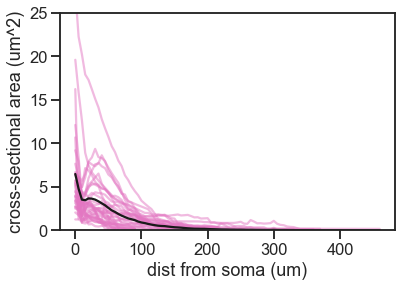

In [128]:
plot_profiles(human_profiles.values())

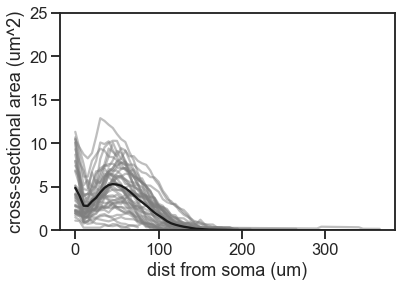

In [129]:
plot_profiles(mouse_profiles.values(), color=species_palette['mouse'])

In [ ]:
#plot dendrogram?